<a href="https://colab.research.google.com/github/samteo/AI-competition/blob/master/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import drive
drive.mount('/content/gdrive')
import os
cwd = os.getcwd()
print(cwd)
print(os.listdir(cwd))
os.chdir('/content/gdrive/MyDrive/SPSS/Data/Price Prediction')
cwd = os.getcwd()

Mounted at /content/gdrive
/content
['.config', 'gdrive', 'sample_data']


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf  
import seaborn as sns

In [ ]:
def fill(df,x,loop):
  '''function to fill the missing data of the timestamp. For example, if there is a missing timestamp between
     08:00:01 and 08:00:03 , 08:00:02 will be filled with the average data from 08:00:01 and 08:00:03
  '''
  index = x.name
  if index != 0:
      if df.iloc[index].isnull().any() == True:
          i = index
          while True:
              print(i)
              print(loop)
              df_next =  df.iloc[i+1]
              if df_next.isnull().any() == False:
                  df.iloc[index] =(df.iloc[index-1] + df_next)/2
                  break
              i+=1
  return df.iloc[index]
        

def datapreprocessing(exchange):
  '''Read csv file and interpolate missing timestamp'''

  df_read01 = pd.read_csv(cwd+r"/exchange-"+str(exchange)+"-orderbook 2020-08-01.csv")
  df_read02 = pd.read_csv(cwd+r"/exchange-"+str(exchange)+"-orderbook 2020-08-02.csv")
#    df_read15 = pd.read_csv(cwd+r"/exchange-"+str(exchange)+"-orderbook 2020-08-01.csv")
#    df_read16 = pd.read_csv(cwd+r"/exchange-"+str(exchange)+"-orderbook 2020-08-01.csv")

  l = [df_read01,df_read02]
  df=pd.DataFrame()
  for i in range(len(l)):
      l[i]['receiveTs'] = pd.to_datetime(l[i]['receiveTs'],format="%Y-%m-%d %H:%M:%S")
      l[i]['receiveTs']=l[i]['receiveTs'].apply(lambda x: x.replace(microsecond=0))
      l[i]= l[i].resample('S',on='receiveTs').mean()
      l[i]=l[i].reset_index()
      timestamp = l[i]['receiveTs']
      l[i]=l[i].drop(['receiveTs'],axis=1)
      l[i]=l[i].apply(lambda x:fill(l[i],x,i),axis=1)
      l[i]['receiveTs'] = timestamp        
      df = df.append(l[i], ignore_index=True)
  return df

dfa = datapreprocessing(exchange="a")  
dfb = datapreprocessing(exchange="b")  
dfc = datapreprocessing(exchange="c")  

In [ ]:
def feature_engineering(df,exchange):



    # Level to pick
    l_cols =[]
    level=8
    for r in range(1,level+1):
        pa = "Pa_"+str(r)
        pb = "Pb_"+str(r)
        va = "Va_"+str(r)
        vb = "Vb_"+str(r)
        l_cols.extend([pa,pb,va,vb])
    
    df_con = df[l_cols]
    df_con.insert(loc=0, column='receiveTs', value= df['receiveTs'])
        
    # Feature engineering(log return/spread/mid_price .etc) 
    for i in range(1, level+1):
        df_con['log_return_ask_{0}_{1}'.format(i,exchange)] = np.log(df_con['Pa_{0}'.format(i)].pct_change() + 1)
        df_con['log_return_bid_{0}_{1}'.format(i,exchange)] = np.log(df_con['Pb_{0}'.format(i)].pct_change() + 1)
        
        df_con['log_ask_{0}_div_bid_{0}_{1}'.format(i,exchange)] = np.log(df_con['Pa_{0}'.format(i)] / df_con['Pb_{0}'.format(i)])
        df_con['log_volume_ask_{0}_div_bid_{0}_{1}'.format(i,exchange)] = np.log(df_con['Va_{0}'.format(i)] / df_con['Vb_{0}'.format(i)])
        
        df_con['log_volume_ask_{0}_{1}'.format(i,exchange)] = np.log(df_con['Va_{0}'.format(i)])
        df_con['log_volume_bid_{0}_{1}'.format(i,exchange)] = np.log(df_con['Vb_{0}'.format(i)])
    
    df_con['log_total_volume_ask_{0}'.format(exchange)] = np.log(df_con[['Va_{0}'.format(x) for x in list(range(1, level + 1))]].sum(axis = 1))
    df_con['log_total_volume_bid_{0}'.format(exchange)] = np.log(df_con[['Vb_{0}'.format(x) for x in list(range(1, level + 1))]].sum(axis = 1))
    df_con['spread_{0}'.format(exchange)] = df_con['Pa_1'] - df_con['Pb_1'] 
    df_con['spread_pct_{0}'.format(exchange)] = (df_con['Pa_1'] - df_con['Pb_1']) /df_con['Pa_1'] 
    df_con['mid_price_{0}'.format(exchange)] = (df_con['Pa_1'] + df_con['Pb_1']) / 2

    if exchange=='a':

        # df_con['return_mid_price'] = (df_con['mid_price'].pct_change(periods=5) + 1)
        # df_con['log_return_mid_price'] = np.log(df_con['mid_price'].pct_change(periods=5) + 1)
        df_con['shift_return_mid_price'] = (df_con['mid_price_a'].pct_change(periods=5) + 1).shift(-5)
        df_con['shift_log_return_mid_price'] = np.log(df_con['mid_price_a'].pct_change(periods=5) + 1).shift(-5)
    df_con = df_con.drop(columns=l_cols)
    return df_con
    
df_a = feature_engineering(dfa,exchange='a')
df_b = feature_engineering(dfb,exchange='b')
df_c = feature_engineering(dfc,exchange='c')
df_final = df_a.merge(df_b,left_on='receiveTs',right_on='receiveTs',how='left')
df_final = df_final.merge(df_c,left_on='receiveTs',right_on='receiveTs',how='left')
# More feature to add 
# Would like to add some TA index to the feature, but colab doesn't have TA library.
df_final['mid_price_dif_a_b'] = df_final['mid_price_a']-df_final['mid_price_b']
df_final['mid_price_dif_a_c'] = df_final['mid_price_a']-df_final['mid_price_c']
df_final['mid_price_dif_a_b_ratio'] = (df_final['mid_price_a']-df_final['mid_price_b'])/df_final['mid_price_a']
df_final['mid_price_dif_a_c_ratio'] = (df_final['mid_price_a']-df_final['mid_price_c'])/df_final['mid_price_a']
df_final['log_total_volume_ask_a_b_ratio'] = (df_final['log_total_volume_ask_a'] - df_final['log_total_volume_ask_b'])/df_final['log_total_volume_ask_a']
df_final['log_total_volume_ask_a_c_ratio'] = (df_final['log_total_volume_ask_a'] - df_final['log_total_volume_ask_c'])/df_final['log_total_volume_ask_a']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
df_final= df_final.dropna()
df_final.head(5)

,receiveTs,log_return_ask_1_a,log_return_bid_1_a,log_ask_1_div_bid_1_a,log_volume_ask_1_div_bid_1_a,log_volume_ask_1_a,log_volume_bid_1_a,log_return_ask_2_a,log_return_bid_2_a,log_ask_2_div_bid_2_a,log_volume_ask_2_div_bid_2_a,log_volume_ask_2_a,log_volume_bid_2_a,log_return_ask_3_a,log_return_bid_3_a,log_ask_3_div_bid_3_a,log_volume_ask_3_div_bid_3_a,log_volume_ask_3_a,log_volume_bid_3_a,log_return_ask_4_a,log_return_bid_4_a,log_ask_4_div_bid_4_a,log_volume_ask_4_div_bid_4_a,log_volume_ask_4_a,log_volume_bid_4_a,log_return_ask_5_a,log_return_bid_5_a,log_ask_5_div_bid_5_a,log_volume_ask_5_div_bid_5_a,log_volume_ask_5_a,log_volume_bid_5_a,log_return_ask_6_a,log_return_bid_6_a,log_ask_6_div_bid_6_a,log_volume_ask_6_div_bid_6_a,log_volume_ask_6_a,log_volume_bid_6_a,log_return_ask_7_a,log_return_bid_7_a,log_ask_7_div_bid_7_a,...,log_return_bid_4_c,log_ask_4_div_bid_4_c,log_volume_ask_4_div_bid_4_c,log_volume_ask_4_c,log_volume_bid_4_c,log_return_ask_5_c,log_return_bid_5_c,log_ask_5_div_bid_5_c,log_volume_ask_5_div_bid_5_c,log_volume_ask_5_c,log_volume_bid_5_c,log_return_ask_6_c,log_return_bid_6_c,log_ask_6_div_bid_6_c,log_volume_ask_6_div_bid_6_c,log_volume_ask_6_c,log_volume_bid_6_c,log_return_ask_7_c,log_return_bid_7_c,log_ask_7_div_bid_7_c,log_volume_ask_7_div_bid_7_c,log_volume_ask_7_c,log_volume_bid_7_c,log_return_ask_8_c,log_return_bid_8_c,log_ask_8_div_bid_8_c,log_volume_ask_8_div_bid_8_c,log_volume_ask_8_c,log_volume_bid_8_c,log_total_volume_ask_c,log_total_volume_bid_c,spread_c,spread_pct_c,mid_price_c,mid_price_dif_a_b,mid_price_dif_a_c,mid_price_dif_a_b_ratio,mid_price_dif_a_c_ratio,log_total_volume_ask_a_b_ratio,log_total_volume_ask_a_c_ratio
3,2020-08-01 00:00:04,0.000174,0.000337,1.948557e-04,3.423176,0.609766,-2.813411,0.000149,0.000325,0.000235,0.342407,-1.777857,-2.120264,0.000109,0.000273,0.000334,-0.751491,0.006976,0.758467,0.000074,0.000252,0.000362,5.698444,3.067355,-2.631089,0.000050,2.557766e-04,0.000371,8.751474,3.453157,-5.298317,0.000002,0.000155,0.000478,4.060443,-2.847312,-6.907755,0.000008,1.499487e-04,0.000503,...,-5.506637e-08,0.000296,0.673524,3.713572,3.040048,0.0,4.680760e-07,0.000330,-3.668358,0.0,3.668358,0.0,0.000001,0.000378,-0.728113,4.919981,5.648094,0.000000,0.000002,0.000443,-3.338832,2.484907,5.823739,0.000000,0.000001,0.000507,-5.175973,0.000000,5.175973,8.599061,7.268321,0.1,0.000009,11352.35,-20.346429,-10.625,-0.001794,-0.000937,-2.022383,-1.132831
4,2020-08-01 00:00:05,-0.000122,0.000072,8.817219e-07,-1.846612,0.431782,2.278395,-0.000064,0.000012,0.000158,4.438328,1.624917,-2.813411,-0.000089,0.000054,0.000191,-2.708050,-4.828314,-2.120264,-0.000075,0.000027,0.000260,-0.749507,0.008960,0.758467,-0.000051,7.936847e-06,0.000312,0.804738,-1.826351,-2.631089,-0.000048,0.000106,0.000324,3.520461,-1.777857,-5.298317,-0.000046,8.907653e-05,0.000369,...,-5.506637e-08,0.000296,0.688281,3.713572,3.025291,0.0,4.680758e-07,0.000329,-3.526361,0.0,3.526361,0.0,0.000001,0.000377,-0.739501,4.919981,5.659482,0.000000,0.000002,0.000440,-3.382128,2.484907,5.867034,0.000000,0.000001,0.000506,-5.188503,0.000000,5.188503,8.605058,7.283173,0.1,0.000009,11352.35,-20.805000,-10.905,-0.001834,-0.000962,-5.063777,-3.110432
5,2020-08-01 00:00:06,0.000000,0.000000,8.817219e-07,-4.609164,-0.716416,3.892748,0.000000,0.000063,0.000094,2.541208,1.624917,-0.916291,0.000000,0.000071,0.000120,-3.001963,-4.828314,-1.826351,0.000025,0.000112,0.000173,-1.827350,-1.826351,0.001000,0.000004,1.111092e-04,0.000205,1.035554,-1.777857,-2.813411,0.000010,0.000101,0.000232,-2.014903,-4.828314,-2.813411,0.000020,1.261047e-04,0.000263,...,-3.524254e-06,0.000300,3.713572,3.713572,0.000000,0.0,-2.290844e-05,0.000352,-5.266999,0.0,5.266999,0.0,-0.000025,0.000402,-1.169064,4.919981,6.089045,0.000000,-0.000044,0.000485,-2.514555,2.484907,4.999462,0.000000,-0.000029,0.000534,-1.992430,0.000000,1.992430,8.932609,7.216342,0.1,0.000009,11352.35,-20.805000,-10.905,-0.001834,-0.000962,-4.039444,-2.453118
6,2020-08-01 00:00:07,0.000017,0.00000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


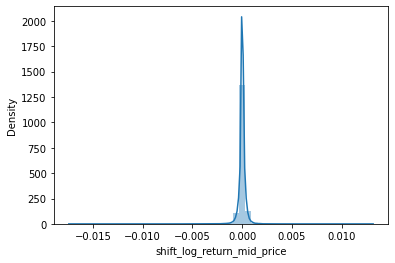

In [ ]:
ax = sns.distplot(df_final['shift_log_return_mid_price']) # check normality

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


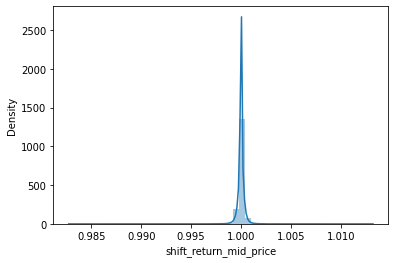

In [ ]:
ax = sns.distplot(df_final['shift_return_mid_price'])

In [ ]:
#Reorder columns name 
col = df_final.columns.tolist()
col.remove('shift_log_return_mid_price')
col.remove('shift_return_mid_price')
col.remove('mid_price_a')
col.insert(0,'mid_price_a')
col.insert(1,'shift_return_mid_price')
col.insert(2,'shift_log_return_mid_price')


In [ ]:
df_final=df_final[col]
#df_final=df_final.loc[:,[col]]
df_final.head(15)


,mid_price_a,shift_return_mid_price,shift_log_return_mid_price,receiveTs,log_return_ask_1_a,log_return_bid_1_a,log_ask_1_div_bid_1_a,log_volume_ask_1_div_bid_1_a,log_volume_ask_1_a,log_volume_bid_1_a,log_return_ask_2_a,log_return_bid_2_a,log_ask_2_div_bid_2_a,log_volume_ask_2_div_bid_2_a,log_volume_ask_2_a,log_volume_bid_2_a,log_return_ask_3_a,log_return_bid_3_a,log_ask_3_div_bid_3_a,log_volume_ask_3_div_bid_3_a,log_volume_ask_3_a,log_volume_bid_3_a,log_return_ask_4_a,log_return_bid_4_a,log_ask_4_div_bid_4_a,log_volume_ask_4_div_bid_4_a,log_volume_ask_4_a,log_volume_bid_4_a,log_return_ask_5_a,log_return_bid_5_a,log_ask_5_div_bid_5_a,log_volume_ask_5_div_bid_5_a,log_volume_ask_5_a,log_volume_bid_5_a,log_return_ask_6_a,log_return_bid_6_a,log_ask_6_div_bid_6_a,log_volume_ask_6_div_bid_6_a,log_volume_ask_6_a,log_volume_bid_6_a,...,log_return_bid_4_c,log_ask_4_div_bid_4_c,log_volume_ask_4_div_bid_4_c,log_volume_ask_4_c,log_volume_bid_4_c,log_return_ask_5_c,log_return_bid_5_c,log_ask_5_div_bid_5_c,log_volume_ask_5_div_bid_5_c,log_volume_ask_5_c,log_volume_bid_5_c,log_return_ask_6_c,log_return_bid_6_c,log_ask_6_div_bid_6_c,log_volume_ask_6_div_bid_6_c,log_volume_ask_6_c,log_volume_bid_6_c,log_return_ask_7_c,log_return_bid_7_c,log_ask_7_div_bid_7_c,log_volume_ask_7_div_bid_7_c,log_volume_ask_7_c,log_volume_bid_7_c,log_return_ask_8_c,log_return_bid_8_c,log_ask_8_div_bid_8_c,log_volume_ask_8_div_bid_8_c,log_volume_ask_8_c,log_volume_bid_8_c,log_total_volume_ask_c,log_total_volume_bid_c,spread_c,spread_pct_c,mid_price_c,mid_price_dif_a_b,mid_price_dif_a_c,mid_price_dif_a_b_ratio,mid_price_dif_a_c_ratio,log_total_volume_ask_a_b_ratio,log_total_volume_ask_a_c_ratio
3,11341.725000,1.000018,0.000018,2020-08-01 00:00:04,1.736931e-04,3.368990e-04,1.948557e-04,3.423176,0.609766,-2.813411,0.000149,3.254360e-04,0.000235,0.342407,-1.777857,-2.120264,0.000109,0.000273,0.000334,-0.751491,0.006976,0.758467,7.405285e-05,0.000252,0.000362,5.698444,3.067355,-2.631089,0.000050,2.557766e-04,0.000371,8.751474,3.453157,-5.298317,0.000002,1.552386e-04,0.000478,4.060443,-2.847312,-6.907755,...,-5.506637e-08,0.000296,0.673524,3.713572,3.040048,0.000000,4.680760e-07,0.000330,-3.668358,0.000000,3.668358,0.000000,1.349203e-06,0.000378,-0.728113,4.919981,5.648094,0.000000e+00,0.000002,0.000443,-3.338832,2.484907,5.823739,0.000000,1.018844e-06,0.000507,-5.175973,0.000000,5.175973,8.599061,7.268321,0.1,0.000009,11352.35,-20.346429,-10.625000,-0.001794,-0.000937,-2.022383,-1.132831
4,11341.445000,1.000029,0.000029,2020-08-01 00:00:05,-1.216702e-04,7.230384e-05,8.817219e-07,-1.846612,0.431782,2.278395,-0.000064,1.234508e-05,0.000158,4.438328,1.624917,-2.813411,-0.000089,0.000054,0.000191,-2.708050,-4.828314,-2.120264,-7.493447e-05,0.000027,0.000260,-0.749507,0.008960,0.758467,-0.000051,7.936847e-06,0.000312,0.804738,-1.826351,-2.631089,-0.000048,1.058307e-04,0.000324,3.520461,-1.777857,-5.298317,...,-5.506637e-08,0.000296,0.688281,3.713572,3.025291,0.000000,4.680758e-07,0.000329,-3.526361,0.000000,3.526361,0.000000,1.349201e-06,0.000377,-0.739501,4.919981,5.659482,0.000000e+00,0.000002,0.000440,-3.382128,2.484907,5.867034,0.000000,1.018843e-06,0.000506,-5.188503,0.000000,5.188503,8.605058,7.283173,0.1,0.000009,11352.35,-20.805000,-10.905000,-0.001834,-0.000962,-5.063777,-3.110432
5,11341.445000,1.000021,0.000020,2020-08-01 00:00:06,0.000000e+00,0.000000e+00,8.817219e-07,-4.609164,-0.716416,3.892748,0.000000,6.348658e-05,0.000094,2.541208,1.624917,-0.916291,0.000000,0.000071,0.000120,-3.001963,-4.828314,-1.826351,2.468491e-05,0.000112,0.000173,-1.827350,-1.826351,0.001000,0.000004,1.111092e-04,0.000205,1.035554,-1.777857,-2.813411,0.000010,1.014105e-04,0.000232,-2.014903,-4.828314,-2.813411,...,-3.524254e-06,0.000300,3.713572,3.713572,0.000000,0.000000,-2.290844e-05,0.000352,-5.266999,0.000000,5.266999,0.000000,-2.525881e-05,0.000402,-1.169064,4.919981,6.089045,0.000000e+00,-0.000044,0.000485,-2.514555,2.484907,4.999462,0.000000,-2.878502e-05,0.000534,-1.992430,0.00000

In [ ]:
df_final.dtypes

mid_price_a                              float64
shift_return_mid_price                   float64
shift_log_return_mid_price               float64
receiveTs                         datetime64[ns]
log_return_ask_1_a                       float64
                                       ...      
mid_price_dif_a_c                        float64
mid_price_dif_a_b_ratio                  float64
mid_price_dif_a_c_ratio                  float64
log_total_volume_ask_a_b_ratio           float64
log_total_volume_ask_a_c_ratio           float64
Length: 168, dtype: object

In [ ]:
df_train = df_final.copy()
target_y= df_train['shift_log_return_mid_price']
df_train = df_train.drop(columns=['receiveTs','mid_price_a','mid_price_b','mid_price_c','shift_return_mid_price','shift_log_return_mid_price']).reset_index(drop=True)
df_train.head(15)

,log_return_ask_1_a,log_return_bid_1_a,log_ask_1_div_bid_1_a,log_volume_ask_1_div_bid_1_a,log_volume_ask_1_a,log_volume_bid_1_a,log_return_ask_2_a,log_return_bid_2_a,log_ask_2_div_bid_2_a,log_volume_ask_2_div_bid_2_a,log_volume_ask_2_a,log_volume_bid_2_a,log_return_ask_3_a,log_return_bid_3_a,log_ask_3_div_bid_3_a,log_volume_ask_3_div_bid_3_a,log_volume_ask_3_a,log_volume_bid_3_a,log_return_ask_4_a,log_return_bid_4_a,log_ask_4_div_bid_4_a,log_volume_ask_4_div_bid_4_a,log_volume_ask_4_a,log_volume_bid_4_a,log_return_ask_5_a,log_return_bid_5_a,log_ask_5_div_bid_5_a,log_volume_ask_5_div_bid_5_a,log_volume_ask_5_a,log_volume_bid_5_a,log_return_ask_6_a,log_return_bid_6_a,log_ask_6_div_bid_6_a,log_volume_ask_6_div_bid_6_a,log_volume_ask_6_a,log_volume_bid_6_a,log_return_ask_7_a,log_return_bid_7_a,log_ask_7_div_bid_7_a,log_volume_ask_7_div_bid_7_a,...,log_return_ask_4_c,log_return_bid_4_c,log_ask_4_div_bid_4_c,log_volume_ask_4_div_bid_4_c,log_volume_ask_4_c,log_volume_bid_4_c,log_return_ask_5_c,log_return_bid_5_c,log_ask_5_div_bid_5_c,log_volume_ask_5_div_bid_5_c,log_volume_ask_5_c,log_volume_bid_5_c,log_return_ask_6_c,log_return_bid_6_c,log_ask_6_div_bid_6_c,log_volume_ask_6_div_bid_6_c,log_volume_ask_6_c,log_volume_bid_6_c,log_return_ask_7_c,log_return_bid_7_c,log_ask_7_div_bid_7_c,log_volume_ask_7_div_bid_7_c,log_volume_ask_7_c,log_volume_bid_7_c,log_return_ask_8_c,log_return_bid_8_c,log_ask_8_div_bid_8_c,log_volume_ask_8_div_bid_8_c,log_volume_ask_8_c,log_volume_bid_8_c,log_total_volume_ask_c,log_total_volume_bid_c,spread_c,spread_pct_c,mid_price_dif_a_b,mid_price_dif_a_c,mid_price_dif_a_b_ratio,mid_price_dif_a_c_ratio,log_total_volume_ask_a_b_ratio,log_total_volume_ask_a_c_ratio
0,1.736931e-04,3.368990e-04,1.948557e-04,3.423176,0.609766,-2.813411,0.000149,3.254360e-04,0.000235,0.342407,-1.777857,-2.120264,0.000109,0.000273,0.000334,-0.751491,0.006976,0.758467,7.405285e-05,0.000252,0.000362,5.698444,3.067355,-2.631089,0.000050,2.557766e-04,0.000371,8.751474,3.453157,-5.298317,0.000002,1.552386e-04,0.000478,4.060443,-2.847312,-6.907755,0.000008,1.499487e-04,0.000503,-1.832333,...,0.000000e+00,-5.506637e-08,0.000296,0.673524,3.713572,3.040048,0.000000,4.680760e-07,0.000330,-3.668358,0.000000,3.668358,0.000000,1.349203e-06,0.000378,-0.728113,4.919981,5.648094,0.000000e+00,0.000002,0.000443,-3.338832,2.484907,5.823739,0.000000,1.018844e-06,0.000507,-5.175973,0.000000,5.175973,8.599061,7.268321,0.1,0.000009,-20.346429,-10.625000,-0.001794,-0.000937,-2.022383,-1.132831
1,-1.216702e-04,7.230384e-05,8.817219e-07,-1.846612,0.431782,2.278395,-0.000064,1.234508e-05,0.000158,4.438328,1.624917,-2.813411,-0.000089,0.000054,0.000191,-2.708050,-4.828314,-2.120264,-7.493447e-05,0.000027,0.000260,-0.749507,0.008960,0.758467,-0.000051,7.936847e-06,0.000312,0.804738,-1.826351,-2.631089,-0.000048,1.058307e-04,0.000324,3.520461,-1.777857,-5.298317,-0.000046,8.907653e-05,0.000369,-2.862201,...,0.000000e+00,-5.506637e-08,0.000296,0.688281,3.713572,3.025291,0.000000,4.680758e-07,0.000329,-3.526361,0.000000,3.526361,0.000000,1.349201e-06,0.000377,-0.739501,4.919981,5.659482,0.000000e+00,0.000002,0.000440,-3.382128,2.484907,5.867034,0.000000,1.018843e-06,0.000506,-5.188503,0.000000,5.188503,8.605058,7.283173,0.1,0.000009,-20.805000,-10.905000,-0.001834,-0.000962,-5.063777,-3.110432
2,0.000000e+00,0.000000e+00,8.817219e-07,-4.609164,-0.716416,3.892748,0.000000,6.348658e-05,0.000094,2.541208,1.624917,-0.916291,0.000000,0.000071,0.000120,-3.001963,-4.828314,-1.826351,2.468491e-05,0.000112,0.000173,-1.827350,-1.826351,0.001000,0.000004,1.111092e-04,0.000205,1.035554,-1.777857,-2.813411,0.000010,1.014105e-04,0.000232,-2.014903,-4.828314,-2.813411,0.000020,1.261047e-04,0.000263,-1.968111,...,2.220446e-16,-3.524254e-06,0.000300,3.713572,3.713572,0.000000,0.000000,-2.290844e-05,0.000352,-5.266999,0.000000,5.266999,0.000000,-2.525881e-05,0.000402,-1.169064,4.919981,6.089045,0.000000e+00,-0.000044,0.000485,-2.514555,2.484907,4.999462,0.000000,-2.878502e-05,0.000534,-

In [ ]:
#https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
scaler = MinMaxScaler()
target_y = scaler.fit_transform(np.array(target_y).reshape(-1,1))
target_y

array([[0.57100455],
       [0.57136743],
       [0.57109891],
       ...,
       [0.58017254],
       [0.58017254],
       [0.58124233]])

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df_train,target_y,test_size=0.1,random_state=123,shuffle=False) #Should not shuffle the data when the data is Time Series Data

In [ ]:
x_train

,log_return_ask_1_a,log_return_bid_1_a,log_ask_1_div_bid_1_a,log_volume_ask_1_div_bid_1_a,log_volume_ask_1_a,log_volume_bid_1_a,log_return_ask_2_a,log_return_bid_2_a,log_ask_2_div_bid_2_a,log_volume_ask_2_div_bid_2_a,log_volume_ask_2_a,log_volume_bid_2_a,log_return_ask_3_a,log_return_bid_3_a,log_ask_3_div_bid_3_a,log_volume_ask_3_div_bid_3_a,log_volume_ask_3_a,log_volume_bid_3_a,log_return_ask_4_a,log_return_bid_4_a,log_ask_4_div_bid_4_a,log_volume_ask_4_div_bid_4_a,log_volume_ask_4_a,log_volume_bid_4_a,log_return_ask_5_a,log_return_bid_5_a,log_ask_5_div_bid_5_a,log_volume_ask_5_div_bid_5_a,log_volume_ask_5_a,log_volume_bid_5_a,log_return_ask_6_a,log_return_bid_6_a,log_ask_6_div_bid_6_a,log_volume_ask_6_div_bid_6_a,log_volume_ask_6_a,log_volume_bid_6_a,log_return_ask_7_a,log_return_bid_7_a,log_ask_7_div_bid_7_a,log_volume_ask_7_div_bid_7_a,...,log_return_ask_4_c,log_return_bid_4_c,log_ask_4_div_bid_4_c,log_volume_ask_4_div_bid_4_c,log_volume_ask_4_c,log_volume_bid_4_c,log_return_ask_5_c,log_return_bid_5_c,log_ask_5_div_bid_5_c,log_volume_ask_5_div_bid_5_c,log_volume_ask_5_c,log_volume_bid_5_c,log_return_ask_6_c,log_return_bid_6_c,log_ask_6_div_bid_6_c,log_volume_ask_6_div_bid_6_c,log_volume_ask_6_c,log_volume_bid_6_c,log_return_ask_7_c,log_return_bid_7_c,log_ask_7_div_bid_7_c,log_volume_ask_7_div_bid_7_c,log_volume_ask_7_c,log_volume_bid_7_c,log_return_ask_8_c,log_return_bid_8_c,log_ask_8_div_bid_8_c,log_volume_ask_8_div_bid_8_c,log_volume_ask_8_c,log_volume_bid_8_c,log_total_volume_ask_c,log_total_volume_bid_c,spread_c,spread_pct_c,mid_price_dif_a_b,mid_price_dif_a_c,mid_price_dif_a_b_ratio,mid_price_dif_a_c_ratio,log_total_volume_ask_a_b_ratio,log_total_volume_ask_a_c_ratio
0,0.000174,0.000337,1.948557e-04,3.423176,0.609766,-2.813411,0.000149,3.254360e-04,0.000235,0.342407,-1.777857,-2.120264,0.000109,0.000273,0.000334,-0.751491,0.006976,0.758467,0.000074,0.000252,0.000362,5.698444,3.067355,-2.631089,0.000050,2.557766e-04,0.000371,8.751474,3.453157,-5.298317,0.000002,0.000155,0.000478,4.060443,-2.847312,-6.907755,7.933902e-06,1.499487e-04,0.000503,-1.832333,...,0.000000e+00,-5.506637e-08,0.000296,0.673524,3.713572,3.040048,0.000000,4.680760e-07,0.000330,-3.668358,0.000000,3.668358,0.000000,0.000001,0.000378,-0.728113,4.919981,5.648094,0.000000e+00,0.000002,0.000443,-3.338832,2.484907,5.823739,0.000000,0.000001,0.000507,-5.175973,0.000000,5.175973,8.599061,7.268321,0.1,0.000009,-20.346429,-10.6250,-0.001794,-0.000937,-2.022383,-1.132831
1,-0.000122,0.000072,8.817219e-07,-1.846612,0.431782,2.278395,-0.000064,1.234508e-05,0.000158,4.438328,1.624917,-2.813411,-0.000089,0.000054,0.000191,-2.708050,-4.828314,-2.120264,-0.000075,0.000027,0.000260,-0.749507,0.008960,0.758467,-0.000051,7.936847e-06,0.000312,0.804738,-1.826351,-2.631089,-0.000048,0.000106,0.000324,3.520461,-1.777857,-5.298317,-4.584119e-05,8.907653e-05,0.000369,-2.862201,...,0.000000e+00,-5.506637e-08,0.000296,0.688281,3.713572,3.025291,0.000000,4.680758e-07,0.000329,-3.526361,0.000000,3.526361,0.000000,0.000001,0.000377,-0.739501,4.919981,5.659482,0.000000e+00,0.000002,0.000440,-3.382128,2.484907,5.867034,0.000000,0.000001,0.000506,-5.188503,0.000000,5.188503,8.605058,7.283173,0.1,0.000009,-20.805000,-10.9050,-0.001834,-0.000962,-5.063777,-3.110432
2,0.000000,0.000000,8.817219e-07,-4.609164,-0.716416,3.892748,0.000000,6.348658e-05,0.000094,2.541208,1.624917,-0.916291,0.000000,0.000071,0.000120,-3.001963,-4.828314,-1.826351,0.000025,0.000112,0.000173,-1.827350,-1.826351,0.001000,0.000004,1.111092e-04,0.000205,1.035554,-1.777857,-2.813411,0.000010,0.000101,0.000232,-2.014903,-4.828314,-2.813411,2.027617e-05,1.261047e-04,0.000263,-1.968111,...,2.220446e-16,-3.524254e-06,0.000300,3.713572,3.713572,0.000000,0.000000,-2.290844e-05,0.000352,-5.266999,0.000000,5.266999,0.000000,-0.000025,0.000402,-1.169064,4.919981,6.089045,0.000000e+00,-0.000044,0.000485,-2.514555,2.484907,4.999462,0.000000,-0.000029,0.000534,-1.992430,0.000000,1.992430,8.932609,7.216342,0.1,0.000009,-20.80

In [ ]:
#scaling input variable
scaler = StandardScaler()
data_scaled_train = scaler.fit_transform(x_train)
data_scaled_test =scaler.transform(x_test)

In [ ]:
print((data_scaled_train.shape),(y_train.shape))
print(data_scaled_test.shape,(y_test.shape))

(155510, 162) (155510, 1)
(17279, 162) (17279, 1)


In [ ]:
win_length = 40   # window length that you need to include in the input data for predicting the next target 
batch_size = 64   # number of training examples utilized in one iteration
num_feature = 162 # Total input feature

train_generator = TimeseriesGenerator(data_scaled_train,y_train,length=win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(data_scaled_test,y_test,length=win_length,sampling_rate=1,batch_size=batch_size)

In [ ]:
train_generator[0]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from keras.layers import Dropout,LeakyReLU,TimeDistributed,RepeatVector,BatchNormalization
import tensorflow as tf

In [ ]:
model = Sequential()
model.add(GRU(units = 128,return_sequences = True, input_shape = (win_length, num_feature)))

model.add(GRU(units = 64, return_sequences = True))


model.add(GRU(units =32, return_sequences = False))

model.add((Dense(1)))
model.summary() 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 40, 128)           112128    
_________________________________________________________________
gru_17 (GRU)                 (None, 40, 64)            37248     
_________________________________________________________________
gru_18 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 158,817
Trainable params: 158,817
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min') #training will be stopped if val_loss is not decreasing after two epoch
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4,decay_steps=500,decay_rate=0.9) #decay lr during training
model.compile(loss=tf.losses.MeanAbsoluteError(),optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),metrics=[tf.metrics.MeanAbsolutePercentageError()])
history = model.fit(train_generator, epochs=30,validation_data=test_generator,shuffle=False,callbacks=[early_stopping])


Epoch 1/30
2430/2430 [==============================] - 336s 136ms/step - loss: 0.0102 - mean_absolute_percentage_error: 1368.1324 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 1.5551
Epoch 2/30
2430/2430 [==============================] - 337s 138ms/step - loss: 0.0074 - mean_absolute_percentage_error: 1254.4710 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 1.4046
Epoch 3/30
2430/2430 [==============================] - 336s 138ms/step - loss: 0.0062 - mean_absolute_percentage_error: 1232.3528 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 1.3832
Epoch 4/30
2430/2430 [==============================] - 335s 138ms/step - loss: 0.0058 - mean_absolute_percentage_error: 1166.6329 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 1.2580
Epoch 5/30
2430/2430 [==============================] - 336s 138ms/step - loss: 0.0055 - mean_absolute_percentage_error: 1149.5447 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 1.2124
Epoch 6/30
2430/2430 [===

In [ ]:
predict = model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
y_test_lag40 = y_test[40:] # window length was set at 40. The prediction was started after the first 40 steps.

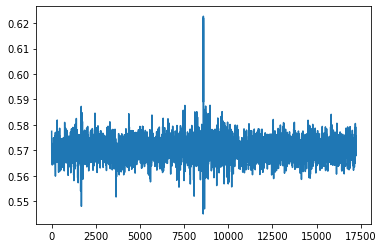

In [ ]:
plt.plot(predict, label = "line 2") #Showing the predicted result

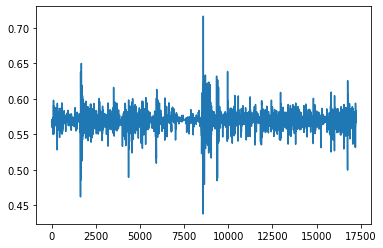

In [ ]:
plt.plot(y_test_lag40, label = "line 2") #Showing the y_test data

In [ ]:
'''
Will continuously fit the model again with the data of day 15-16. 
'''